# Feature Engineering

After the Exploratory Data Analysis, this notebook will be dedicated to define the data preprocessing steps that will be part of the final ML pipeline. Steps are adjusted for sklearn's API conventions, to be able to build an sklearn pipeline.

In [25]:
import pandas as pd
import pickle
%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from feature_engine.transformation import LogTransformer
from preprocessors import OutliersTransformer, SquareRootTransformer

In [26]:
DATA_PATH = "../../data/breast_cancer_wisconsin_diagnostic_dataset.csv"
TARGET = 'diagnosis'
COLUMNS_TO_DROP = ['id', 'Unnamed: 32']

### Load data:

Dataset Breast Cancer Wisconsin (Diagnostic) Data Set from [Kaggle](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download).

In [27]:
df = pd.read_csv(DATA_PATH)
df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


### Separate dataset into train and test

It is important to separate the data into training and testing sets. When engineering features, some techniques learn parameters from data, it is important to learn these parameters only from the train set to avoid over-fitting.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(COLUMNS_TO_DROP + [TARGET], axis=1), # X
    df[TARGET], # y
    test_size=0.1, # Portion of dataset to allocate to test set.
    random_state=8, # Setting the seed for reproducibility.
    stratify=df[TARGET] # Ensures proportion of samples for each class will be preserved.
)

X_train.shape, X_test.shape

((512, 30), (57, 30))

### Target

Let's binaryze the target variable.

In [29]:
y_train = y_train.map({'M':1,'B':0})
y_test = y_test.map({'M':1,'B':0})

### Feature preprocessing Steps

Steps include: 

- Outliers detection and treatment
- Transformations of Non-Gaussian distributions
- Scaling

#### Preprocessing steps Config

In [30]:
THRESHOLD = 4
LIMITS = 0.1
SQUARE_ROOT_VARS = X_train.columns[(X_train == 0).any()].tolist()
LOG_TRANSFORM_VARS = [col_name for col_name in X_train.columns \
                    if not col_name in SQUARE_ROOT_VARS]

In [31]:
# Printing for future config purposes. 
print(f"Square Root Vars: {SQUARE_ROOT_VARS}")
print(f"Square Root Vars: {LOG_TRANSFORM_VARS}")

Square Root Vars: ['concavity_mean', 'concave points_mean', 'concavity_se', 'concave points_se', 'concavity_worst', 'concave points_worst']
Square Root Vars: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'symmetry_worst', 'fractal_dimension_worst']


#### Utility functions

In [32]:
def check_for_null_values(X):
    """
    Check for null values in the columns of the DataFrame.

    Parameters:
    -----------
    X : pandas DataFrame
        Input DataFrame to check for null values.

    Returns:
    --------
    None
    """
    if not [var for var in X.columns if X[var].isnull().sum() > 0]:
        print("There are no null values.")
    else:
        print("Null values have been found.")

In [33]:
def plot_bar_counts(y):
    """
    Create a bar plot showing the counts of each category in the target variable.

    Parameters:
    -----------
    y : pandas Series
        Input Series containing the target variable.

    Returns:
    --------
    None
    """
    # Calculate value counts for the target variable
    counts = y.value_counts()

    # Create the bar plot
    ax = counts.plot(kind='bar', color=['blue', 'orange'], figsize=(5, 5))

    # Add labels and title
    plt.xlabel(TARGET)
    plt.ylabel('Counts')
    plt.title(f'Bar plot of {TARGET} (Target variable)')

    # Adding total counts on top of each bar.
    for i, count in enumerate(counts):
        ax.text(i, count + 1, str(count), ha='center')

    # Show the plot
    plt.show()

#### Step 1: Outliers detection and treatment

In [34]:
outliers_transformer = OutliersTransformer(
    variables=X_train.columns.tolist(),
    threshold=THRESHOLD,
    limits=LIMITS
)

X_train = outliers_transformer.fit_transform(X_train)
X_test = outliers_transformer.fit_transform(X_test)

In [35]:
# Checking there are no null values after the transformation.
print("X_train check:")
check_for_null_values(X_train)
print("X_test check:")
check_for_null_values(X_test)

X_train check:
There are no null values.
X_test check:
There are no null values.


#### Step 2: Transformations of Non-Gaussian distributions

##### Square root Transformation:

In [36]:
square_root_transformer = SquareRootTransformer(
    variables=SQUARE_ROOT_VARS
)

X_train = square_root_transformer.fit_transform(X_train)
X_test = square_root_transformer.transform(X_test)

In [37]:
# Checking there are no null values after the transformation.
print("X_train check:")
check_for_null_values(X_train)
print("X_test check:")
check_for_null_values(X_test)

X_train check:
There are no null values.
X_test check:
There are no null values.


##### Logarithmic Transformation:

In [38]:
log_transformer = LogTransformer(
    variables=LOG_TRANSFORM_VARS
)

X_train = log_transformer.fit_transform(X_train)
X_test = log_transformer.transform(X_test)

In [39]:
# Checking there are no null values after the transformation.
print("X_train check:")
check_for_null_values(X_train)
print("X_test check:")
check_for_null_values(X_test)

X_train check:
There are no null values.
X_test check:
There are no null values.


#### Step 3: Scaling

In [40]:
# Scaling data to 0-1 range.

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)
X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

In [41]:
# Checking there are no null values after the transformation.
print("X_train check:")
check_for_null_values(X_train)
print("X_test check:")
check_for_null_values(X_test)

X_train check:
There are no null values.
X_test check:
There are no null values.


#### Final checks

y_train:


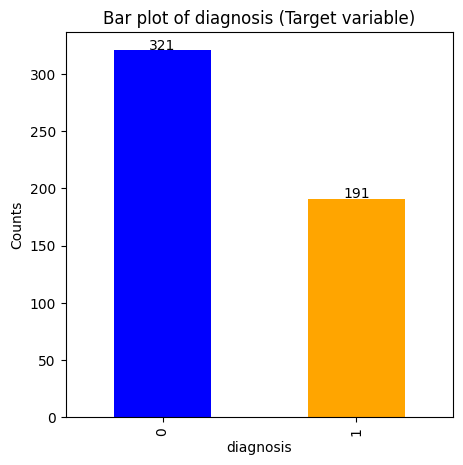

In [42]:
print("y_train:")
plot_bar_counts(y_train)

y_test:


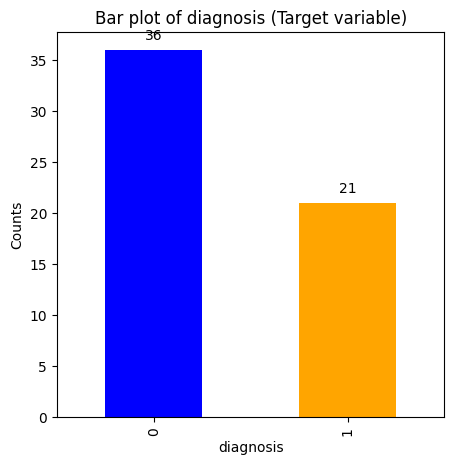

In [43]:
print("y_test:")
plot_bar_counts(y_test)

In [44]:
X_train.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.509751,0.600137,0.511635,0.553427,0.522879,0.600503,0.367246,0.389856,0.369367,0.329906,...,0.510337,0.578198,0.527581,0.529113,0.423103,0.731524,0.517305,0.679152,0.403221,0.356497
1,0.922115,0.755140,0.935250,0.974266,0.695072,0.939804,0.943107,0.957600,0.573738,0.546151,...,0.930590,0.726270,0.947281,0.927816,0.695501,0.896875,0.830596,0.993780,0.341844,0.650196
2,0.443599,0.401316,0.439216,0.483151,0.639595,0.471822,0.404918,0.409262,0.515209,0.461993,...,0.384434,0.357048,0.373841,0.406449,0.643833,0.585363,0.488605,0.603127,0.644578,0.557043
3,0.438034,0.632279,0.435001,0.483741,0.356918,0.489564,0.403963,0.304620,0.419818,0.360861,...,0.417248,0.571692,0.394476,0.441128,0.244177,0.566299,0.442496,0.439247,0.387873,0.393471
4,0.559552,0.920565,0.588617,0.609421,0.681020,0.845289,0.824182,0.684572,0.732989,0.641073,...,0.554412,0.896572,0.618741,0.564185,0.603909,0.973373,0.782927,0.900874,0.804119,0.946261


In [45]:
X_test.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.381082,0.638630,0.385143,0.417529,0.225768,0.584838,0.483533,0.344367,0.253575,0.500787,...,0.334323,0.601635,0.333221,0.355808,0.249292,0.728985,0.585504,0.54901,0.323864,0.595098
1,0.239246,0.383610,0.232673,0.266409,0.534545,0.268055,0.171412,0.264444,0.709499,0.417813,...,0.212796,0.389928,0.198464,0.230000,0.634320,0.356547,0.207534,0.42156,0.499032,0.396441
2,0.803194,0.353910,0.802552,0.859176,0.635652,0.721456,0.717392,0.789783,0.653447,0.380915,...,0.735265,0.421669,0.729019,0.746902,0.452275,0.677052,0.654735,0.82294,0.465641,0.455350
3,0.467050,0.923178,0.465089,0.513946,0.557045,0.445803,0.274031,0.402774,0.273653,0.331987,...,0.448126,0.876826,0.429959,0.472405,0.437436,0.476911,0.273136,0.51712,0.283278,0.332698
4,0.598566,0.565022,0.593239,0.659263,0.548775,0.494552,0.510127,0.574387,0.555759,0.135974,...,0.638916,0.504549,0.619254,0.666653,0.653828,0.582131,0.548976,0.72360,0.440723,0.147160


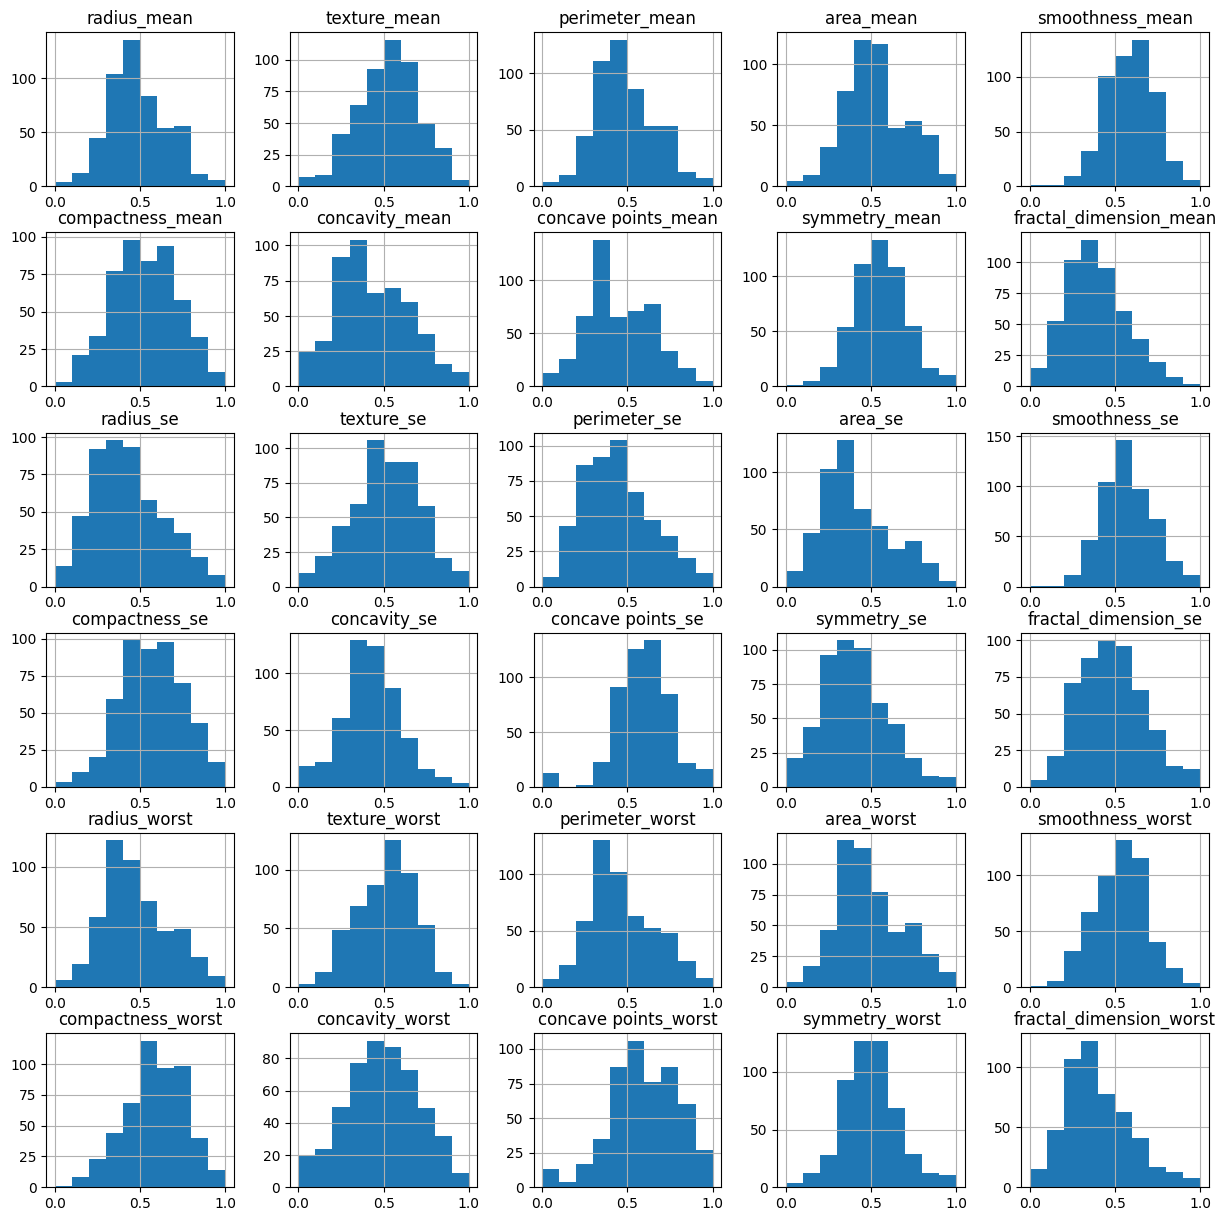

In [46]:
X_train.hist(figsize=(15,15))
plt.show()

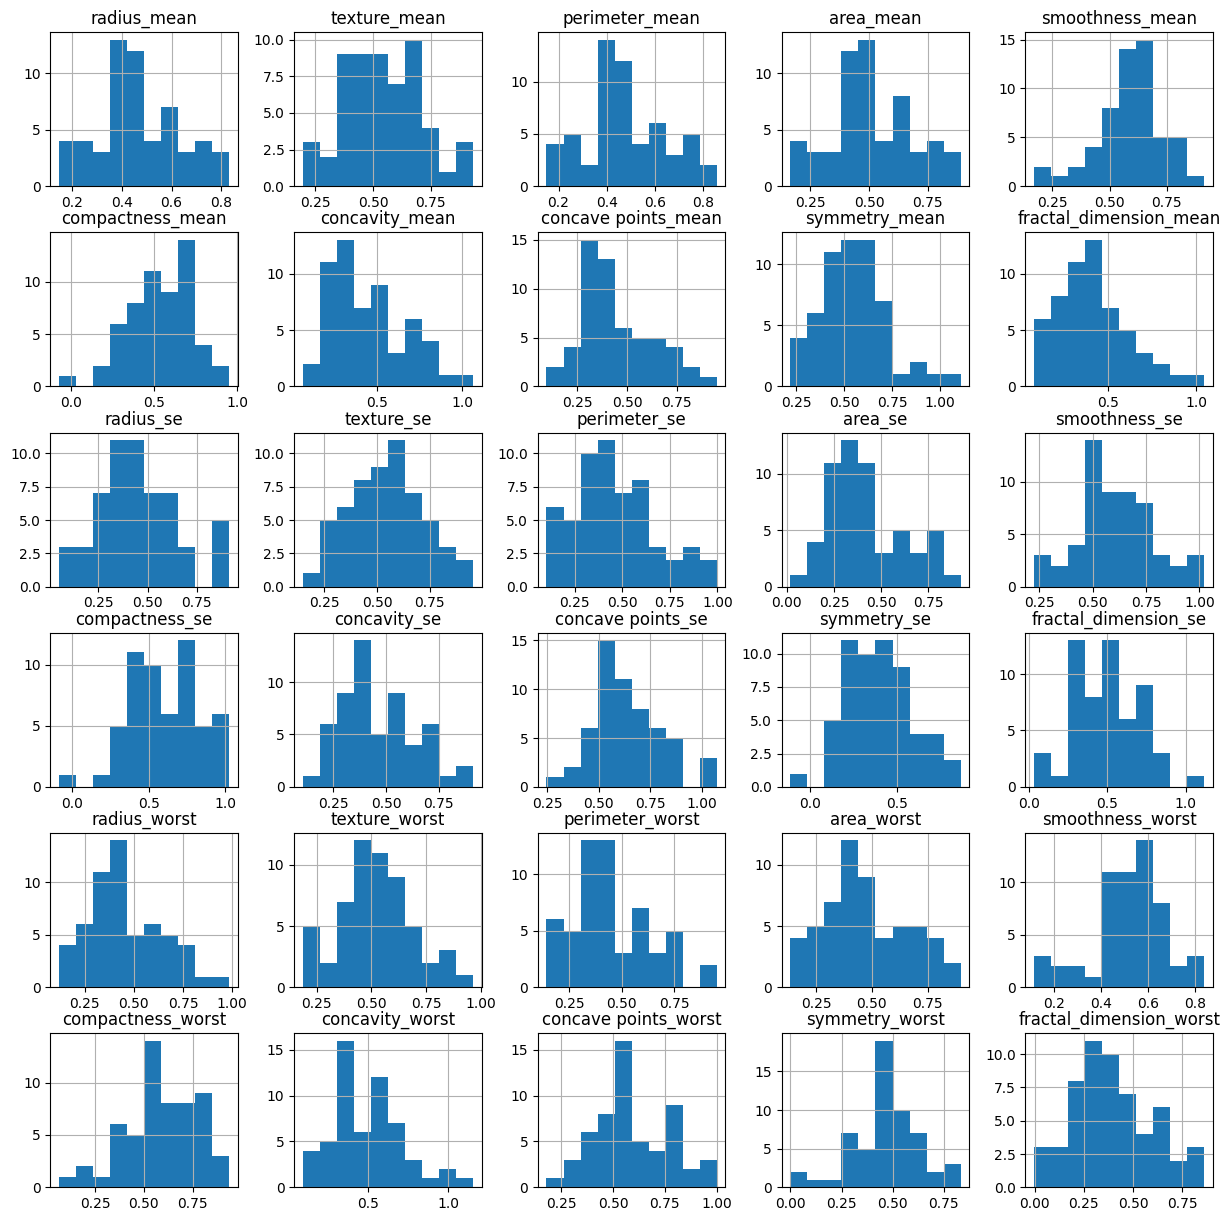

In [47]:
X_test.hist(figsize=(15,15))
plt.show()

### Store preprocessed Dataset:

In [48]:
# Save datasets as a pickle file
with open('../outputs/processed_dataset.pkl', 'wb') as f:
    pickle.dump((X_train, y_train, X_test, y_test), f)